In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from multitask_sparse_parity import generate_multitask_sparse_parity_dataset

In [2]:
import jax
import jax.numpy as jnp
import equinox as eqx
from typing import Sequence, Callable, Dict
import optax


class MLP(eqx.Module):
    layers: Sequence[eqx.nn.Linear]
    activation: Callable = eqx.static_field()

    def __init__(
        self,
        in_size: int,
        hidden_sizes: Sequence[int],
        out_size: int,
        key: jax.random.PRNGKey
    ):
        keys = jax.random.split(key, len(hidden_sizes) + 1)
        layers = []
        sizes = [in_size] + list(hidden_sizes) + [out_size]
        for in_size, out_size, key in zip(sizes[:-1], sizes[1:], keys):
            layers.append(eqx.nn.Linear(in_size, out_size, key=key))
        self.layers = layers
        self.activation = jax.nn.relu

    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return jax.nn.sigmoid(self.layers[-1](x))

@eqx.filter_value_and_grad
def loss_fn(
    model: MLP,
    x: jnp.ndarray,
    y: jnp.ndarray
) -> jnp.ndarray:
    pred = jax.vmap(model)(x)
    return jnp.mean(optax.sigmoid_binary_cross_entropy(pred, y))

@eqx.filter_jit
def make_step(
    model: MLP,
    x: jnp.ndarray,
    y: jnp.ndarray,
    opt_state,
    optimizer
):
    loss, grads = loss_fn(model, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

@eqx.filter_jit
def compute_accuracy(
    model: MLP,
    x: jnp.ndarray,
    y: jnp.ndarray
) -> float:
    preds = jax.vmap(model)(x) > 0.5
    return jnp.mean(preds == y)


# @eqx.filter_jit
def compute_task_losses(
    model: MLP,
    features: jnp.ndarray,
    labels: jnp.ndarray,
    n_tasks: int
) -> Dict[int, float]:
    task_losses = {}
    
    def loss_for_task(task_idx):
        task_mask = features[:, task_idx] == 1
        task_features = features[task_mask]
        task_labels = labels[task_mask]
        preds = jax.vmap(model)(task_features)
        return jnp.mean(optax.sigmoid_binary_cross_entropy(preds, task_labels))
    
    for task_idx in range(n_tasks):
        task_losses[task_idx] = loss_for_task(task_idx)
    
    return task_losses

def data_generator(
    features: jnp.ndarray,
    labels: jnp.ndarray,
    batch_size: int,
    key: jax.random.PRNGKey
):
    dataset_size = len(features)
    indices = jnp.arange(dataset_size)
    
    while True:
        key, subkey = jax.random.split(key)
        permuted_indices = jax.random.permutation(subkey, indices)
        
        for start in range(0, dataset_size, batch_size):
            end = min(start + batch_size, dataset_size)
            batch_indices = permuted_indices[start:end]
            yield features[batch_indices], labels[batch_indices]


In [3]:

# Generate dataset
rng_key = jax.random.PRNGKey(0)
data_key, model_key, split_key, gen_key = jax.random.split(rng_key, 4)
n_tasks, n, k = 20, 20, 3
num_train_samples = 50000
num_test_samples = 10000
num_total_samples = num_train_samples + num_test_samples
alpha = 0.4
features, labels, subtasks = generate_multitask_sparse_parity_dataset(
    data_key,
    n_tasks,
    n,
    k,
    num_total_samples, 
    alpha=alpha
)
labels = labels.reshape(-1, 1)

# Split into train and test sets
indices = jnp.arange(num_total_samples)
train_indices = jax.random.choice(split_key, indices, shape=(num_train_samples,), replace=False)
test_indices = jnp.setdiff1d(indices, train_indices)

train_features, train_labels = features[train_indices], labels[train_indices]
test_features, test_labels = features[test_indices], labels[test_indices]

# Create model
input_size = n_tasks + n
hidden_sizes = [128]
output_size = 1
model = MLP(input_size, hidden_sizes, output_size, model_key)

# Training setup
batch_size = 1024
num_steps = 100000
learning_rate = 1e-3

optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

# Create data generator
train_gen = data_generator(train_features, train_labels, batch_size, gen_key)

# Training loop
rec = []
for step in range(num_steps):
    x_batch, y_batch = next(train_gen)
    loss, model, opt_state = make_step(model, x_batch, y_batch, opt_state, optimizer)
    
    if step % 500 == 0:
        test_acc = compute_accuracy(model, test_features, test_labels)
        test_loss, _ = loss_fn(model, test_features, test_labels)
        batch_acc = compute_accuracy(model, x_batch, y_batch)
        print(f"Step {step:+6d}, Loss: {loss:.5f}, Test Acc: {test_acc:.7f}")
        
        # Compute average gradient norm
        _, grads = loss_fn(model, x_batch, y_batch)
        grad_norm = jnp.sqrt(sum(jnp.sum(jnp.square(g)) for g in jax.tree_util.tree_leaves(grads)))
        
        # Compute task-wise test losses
        task_losses = compute_task_losses(model, test_features, test_labels, n_tasks)
        
        rec.append({
            "step": step,
            "loss": float(loss),
            "test_loss": float(test_loss),
            "test_acc": float(test_acc),
            "batch_acc": float(batch_acc),
            "grad_norm": float(grad_norm),
            "task_losses": {k: float(v) for k, v in task_losses.items()}
        })

# After training, compute final test accuracy and task-wise losses
final_test_acc = compute_accuracy(model, test_features, test_labels)
final_task_losses = compute_task_losses(model, test_features, test_labels, n_tasks)
print(f"Final test accuracy: {final_test_acc:.4f}")

# Add final metrics to rec
rec.append({
    "step": num_steps,
    "loss": float(loss),
    "test_acc": float(final_test_acc),
    "batch_acc": float(compute_accuracy(model, x_batch, y_batch)),
    "grad_norm": float(grad_norm),
    "task_losses": {k: float(v) for k, v in final_task_losses.items()}
})

Step     +0, Loss: 0.73369, Test Acc: 0.5033000
Step   +500, Loss: 0.69110, Test Acc: 0.4982000
Step  +1000, Loss: 0.64318, Test Acc: 0.6587000
Step  +1500, Loss: 0.62982, Test Acc: 0.6743000
Step  +2000, Loss: 0.62416, Test Acc: 0.6778000
Step  +2500, Loss: 0.62388, Test Acc: 0.6872000
Step  +3000, Loss: 0.61863, Test Acc: 0.6936000
Step  +3500, Loss: 0.61728, Test Acc: 0.6955000
Step  +4000, Loss: 0.62035, Test Acc: 0.6961000
Step  +4500, Loss: 0.61871, Test Acc: 0.6965000
Step  +5000, Loss: 0.60916, Test Acc: 0.6977000
Step  +5500, Loss: 0.61623, Test Acc: 0.6989000
Step  +6000, Loss: 0.62245, Test Acc: 0.6996000
Step  +6500, Loss: 0.61271, Test Acc: 0.7002000
Step  +7000, Loss: 0.61150, Test Acc: 0.7008000
Step  +7500, Loss: 0.61659, Test Acc: 0.7006000
Step  +8000, Loss: 0.60978, Test Acc: 0.7013000
Step  +8500, Loss: 0.61494, Test Acc: 0.7018000
Step  +9000, Loss: 0.60898, Test Acc: 0.7022000
Step  +9500, Loss: 0.60488, Test Acc: 0.7024000
Step +10000, Loss: 0.60914, Test Acc: 0.

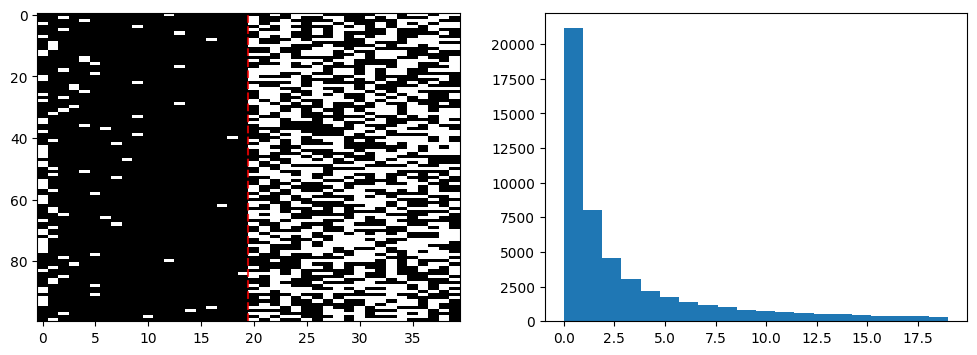

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
ax.imshow(train_features[:100], aspect="auto", cmap="gray");
ymin, ymax = ax.get_ylim()
ax.vlines(n_tasks - 0.6, ymin, ymax, color="r", linestyle="--", alpha=0.8)

ax = axes[1]
ax.hist(jnp.argmax(train_features[:, :n_tasks], axis=1), bins=n_tasks);


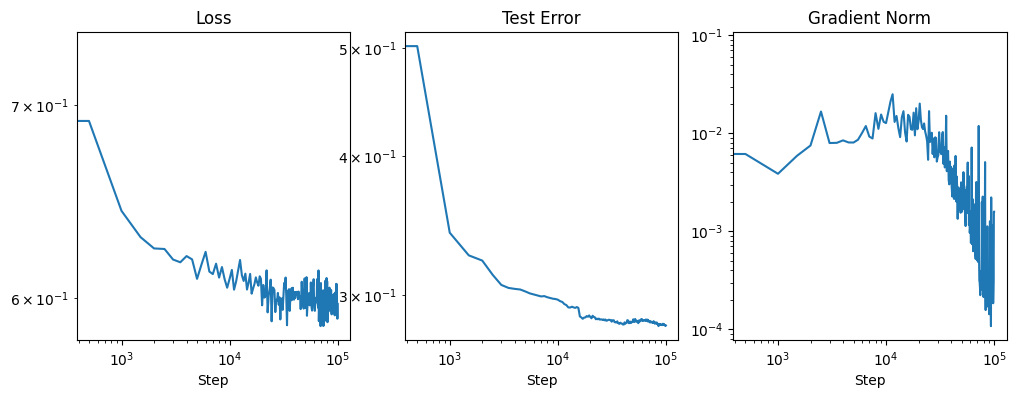

In [12]:
df_rec = pd.DataFrame(rec)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes[0]
ax.plot(df_rec["step"], df_rec["loss"])
ax.set_title("Loss")
ax.set_yscale("log")
ax.set_xscale("log")


ax = axes[1]
ax.plot(df_rec["step"], 1 - df_rec["test_acc"], label="Test Error")
# ax.set_ylim(df_rec["test_acc"].min(), 1)
ax.set_title("Test Error")
ax.set_yscale("log")
ax.set_xscale("log")



ax = axes[2]
ax.plot(df_rec["step"], df_rec["grad_norm"])
ax.set_title("Gradient Norm")
ax.set_yscale("log")
ax.set_xscale("log")



for ax in axes:
    ax.set_xlabel("Step")
    # ax.set_yscale("log")
    # ax.set_xscale("log")


<Axes: xlabel='step', ylabel='loss'>

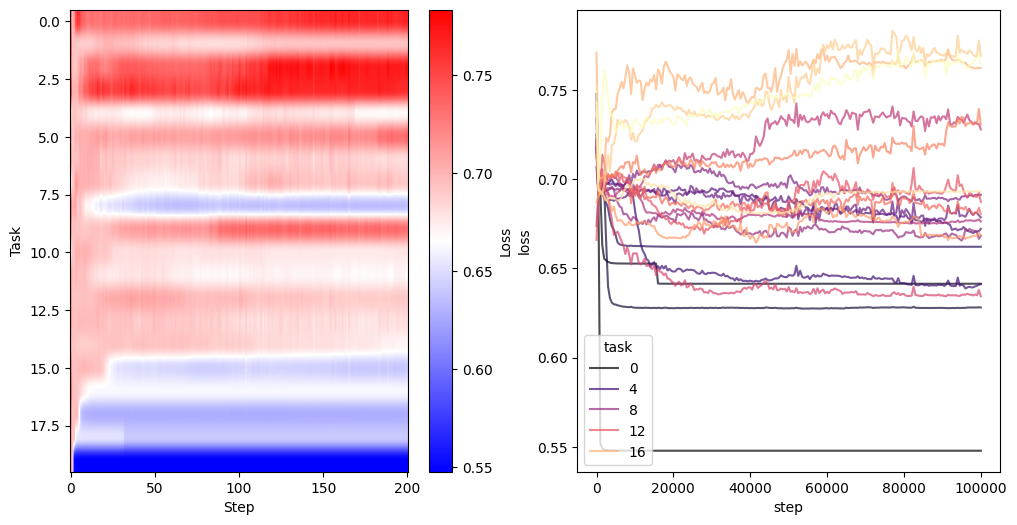

In [19]:
task_losses = df_rec["task_losses"].apply(pd.Series)
task_losses = task_losses.loc[:, sorted(task_losses.columns, reverse=True)]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes[0]
cax = ax.imshow(task_losses.transpose(), aspect="auto", cmap="bwr")
ax.set_xlabel("Step")
ax.set_ylabel("Task")
fig.colorbar(cax, ax=ax, label="Loss")

ax = axes[1]
task_losses["step"] = df_rec["step"]
task_losses = task_losses.melt(id_vars="step", var_name="task", value_name="loss")
sns.lineplot(data=task_losses, x="step", y="loss", hue="task", ax=ax, palette="magma", alpha=0.7)